In [ ]:
# Importing py modules
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

import time

# Setting plot style
plt.style.use("bmh")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA

from tqdm import tqdm

from matplotlib import cm

In [ ]:
# Importing neural-tangents
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt

import dataclasses
import functools
from typing import Callable, Optional

from jax.example_libraries import optimizers
import jax
import jax.config
from jax.config import config as jax_config
jax_config.update('jax_enable_x64', True) # for numerical stability, can disable if not an issue
from jax import numpy as jnp
from jax import scipy as sp
import numpy as np
!pip install tensorflow==2.15.0
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

from neural_tangents import stax


In [ ]:
# Importing functions for Kernel regression from scikit-learn
from sklearn.kernel_ridge import KernelRidge

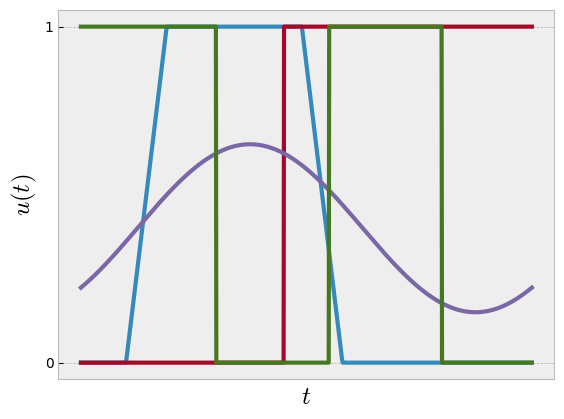

In [ ]:
# Define function families for the control functions in the mixed dataset
# We solve the normalized problem, where t*=1, and t is the normalized time variable

fun_1 = lambda u_0, t, t_0, dt, u_1: np.piecewise(t, [t <= t_0, (t > t_0) * (t <= t_0+0.33*dt), (t > t_0+0.3*dt) * (t <= t_0+dt+0.33*dt), (t > t_0+dt+0.33*dt)*(t <= t_0+dt+2*0.33*dt), t > t_0+dt+2*0.33*dt],[u_0, lambda t:u_0+ (u_1 - u_0)/(0.33*dt) * (t - t_0), u_1, lambda t: u_1 - (u_1 - u_0)/(0.33*dt) * (t - (t_0 + dt + 0.33*dt)), u_0 ])

fun_2 = lambda u_0, t, t_0, dt, u_1: np.piecewise(t, [t <= t_0, t > t_0],[u_0, u_1])

fun_3 = lambda u_0, t, t_0, dt, u_1: u_0/2 * (1 + 0.5 * cos(2*pi*t + dt * pi/2))

fun_4 = lambda u_0, t, t_0, dt, u_1: np.piecewise(t, [t <= t_0, (t > t_0) * (t <= t_0+dt*0.5), (t > t_0+dt*0.5) * (t <= t_0+dt), t > t_0+dt],[u_0, u_1, u_0, u_1])


In [ ]:
# Model parameters for the generation of training data
gamma = 0.05
R0_base = 4
gamma *= 100 # normalization

beta = R0_base * gamma


In [ ]:
# Model function and defintion of parameters for the numerical simulations
fun = lambda t, x, u_: np.array([- u_ * beta * x[0] * x[1] + gamma * x[1], u_ * beta * x[0] * x[1] - gamma * x[1]])

n_steps = 100
dt = 1 / n_steps


In [ ]:
# Set seed for reproducibility of the results
np.random.seed(7293)

n_fun = 4
nm = 500
nm_test = 100

dt = 1 / n_steps

n_comp = 2 # number of compartments

fun_list = [fun_1, fun_2, fun_3, fun_4]

# Defining training dataset
x_train = np.zeros((nm, n_steps))
y_train = np.zeros((nm, n_steps + 1, n_comp))
y_train[:,0, 0] = 0.99
y_train[:,0, 1] = 0.01

# Defining test dataset
x_test  = np.zeros((nm_test, n_steps))
y_test = np.zeros((nm_test, n_steps + 1, n_comp))
y_test[:,0, 0] = 0.99
y_test[:,0, 1] = 0.01

t = np.linspace(0,1, n_steps)

# Constructing training/test datasets
for ii in range(n_fun):
  u_0_test  = np.random.uniform(0.0,1, int(nm_test/n_fun))
  u_1_test  = np.random.uniform(0.0,1, int(nm_test/n_fun))
  dt_test   = np.random.uniform(0,0.3, int(nm_test/n_fun))
  t_0_test  = np.random.uniform(0,1, int(nm_test/n_fun))

  u_0_train = np.random.uniform(0.0,1, int(nm/n_fun))
  u_1_train = np.random.uniform(0.0,1, int(nm/n_fun))
  dt_train  = np.random.uniform(0,0.3, int(nm/n_fun))
  t_0_train = np.random.uniform(0,1, int(nm/n_fun))

  for k in range(int(nm/n_fun)):
      x_train[ii * int(nm/n_fun) + k, :] = fun_list[ii](u_0_train[k], t, t_0_train[k], dt_train[k], u_1_train[k])
      for j in range(y_train.shape[1]-1):
        y_train[ii * int(nm/n_fun) + k, j+1, : ]  = y_train[ii * int(nm/n_fun) + k, j,:] + dt * fun(t[j], y_train[ii * int(nm/n_fun) + k,j,:], x_train[ii * int(nm/n_fun) + k,j])
  for k in range(int(nm_test/n_fun)):
      x_test[ii * int(nm_test/n_fun) + k, :] = fun_list[ii](u_0_test[k], t, t_0_test[k], dt_test[k], u_1_test[k])
      for j in range(y_test.shape[1]-1):
        y_test[ii * int(nm_test/n_fun) + k, j+1,: ]  = y_test[ii * int(nm_test/n_fun)+ k, j,:] + dt * fun(t[j], y_test[ii * int(nm_test/n_fun)+ k,j,:], x_test[ii * int(nm_test/n_fun)+ k,j])


In [ ]:
# Reshaping labels for comaptibility with KOL
y_train = y_train.transpose((0, 2, 1)).reshape(y_train.shape[-3], -1).copy()
y_test = y_test.transpose((0, 2, 1)).reshape(y_test.shape[-3], -1).copy()

In [ ]:
# Saving datasets
np.savetxt('x_train_sird.csv', x_train, delimiter=',')
np.savetxt('y_train_sird.csv', y_train, delimiter=',')
np.savetxt('x_test_sird.csv', x_test, delimiter=',')
np.savetxt('y_test_sird.csv', y_test, delimiter=',')

# **RIDGE REGRESSION**

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)


    model.fit(x_train_pca, y_train)
    pred= model.predict(x_test_pca)

    return pred, model

In [ ]:
model = Ridge(alpha = 1e-10)

In [ ]:
# Computing PCA of inner dataset
pca = PCA(n_components=min(y_train.shape))

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [ ]:
pca_modes = np.arange(1, min(x_train.shape))
errors = []
for n_pca in pca_modes:
    pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    errors.append(e)

In [ ]:
n_pca = pca_modes[best]

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

# **Neural Tangent Kernel (NTK) Regression**

In [ ]:
from jax import jit
from neural_tangents import stax
import neural_tangents as nt
import random

# Defintion of the underlying neural network
_, _, kernel_fn = stax.serial(
        stax.Dense(100, 1., 0.5),
        stax.Sigmoid_like(),#Relu(),
        stax.Dense(100, 1., 0.5),
        stax.Sigmoid_like(),#Relu(),
        stax.Dense(1, 1., 0.5)
        )
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [ ]:
# Auxiliary functions for computing NTK
def generate_ntk(X, Y):
    if X.ndim == 1:
      X = X[None,:]
    if Y.ndim == 1:
      Y = Y[None,:]
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))

    for i in range(m):

      k = np.array(kernel_fn(X, Y[i:i + 1], 'ntk'))

      if k.ndim == 0:
        K[:, i:i + 1] = k
      else:
        K[:, i:i + 1] = k.reshape((k.shape[0],1))
    return K

proxy_kernel_fn = lambda x, y: generate_ntk(x,y)

In [ ]:
# Definition of the Kernel Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
model = KernelRidge(alpha = 1e-10, kernel=proxy_kernel_fn)

In [ ]:
def train_test(x_train, x_test, y_train, y_test, model):

    model.fit(x_train, y_train)
    pred= model.predict(x_test)

    return pred, model

In [ ]:
pca_modes = [min(y_train.shape)]
errors = []
for n_pca in pca_modes:
    start_time = time.time()
    pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test,model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    end_time = time.time()
    errors.append(e)
plt.figure()
plt.plot(pca_modes,errors, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")
plt.show()

In [ ]:
print('Generalization error: ',errors)
print('Time (s): ', end_time-start_time)

# **Gaussian kernels: Matérn, RBF, Rational Quadratic**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

In [ ]:
# Choose the kernels and the parameters
kernel = Matern(nu =0.2)
#kernel = RBF()
#kernel = RationalQuadratic(0.2, alpha=0.5)

model = GaussianProcessRegressor(kernel, alpha = 1e-10)

In [ ]:
pca = PCA(n_components=min(x_train.shape))

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.99)[0][0]
n_pca

In [ ]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test,model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e, model